# Задача анализа данных телеметрии
## [Ильдар А.](https://drive.google.com/file/d/1U_eSjm75ZaUgdOj6WEdcuzDxSr07c5ar/view)

**Дано:**  
Даны участки телеметрии работы оборудования (9 датчиков, 128 сек) соответствующие шести различным режимам. 

**Что сделать:**  
1) Сделать разведочный анализ данных, визуально посмотреть на разделимость режимов работы.  
2) На основе разведочного анализа данных сформировать факторное пространство.  
3) Предсказать режимы работы оборудования на тестовых данных, посчитать точность, полноту, ROC-AUC на y_test.npy.  
4) Добиться показателей метрик выше 0.88 на тестовой выборке (при необходимости добавить факторы).

**Аннотация к решению:**  Проведен визуальный анализ временных рядов замеров, усредненных по всем наблюдениям в тренировочной выборке. Сделаны предположения о структуре факторного пространства, которое дискриминирует режимы работы. Для приближенной проверки устойчивости полученных предположений проведена визуальная проверка их справедливости для первых 1000 наблюдений тренировочной выборки (<15%). На основе проведенного анализа собрана матрица факторов, нормализована по Z-шкале. Для прогноза выбраны алгоритмы метод опорных векторов с гауссовым ядром и перцептрон с одним скрытым слоем. Гиперпараметры подобраны на основе процедуры кросс-валидации. Модели также построены для дополненного факторного пространства на основе статистической проверки гипотез схожести распредлений других факторов (с помощью теста Уилкоксона).  Порог в 0.88 по всем метрикам превышен при 23 факторах алгоритмом метод опорных векторов.

In [1]:
#Импорт системных библиотек
import warnings
warnings.simplefilter("ignore")
import time

#Импорт библиотек для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

#Импорт математических библиотек
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from scipy.stats import ranksums

# Загрузка данных

In [2]:
#Загрузка данных
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")

#Перевод данных в pandas датафрейм
y_train = pd.DataFrame(y_train, columns=['Режим 1', 'Режим 2', 'Режим 3', 'Режим 4', 'Режим 5', 'Режим 6'])
y_test = pd.DataFrame(y_test, columns=['Режим 1', 'Режим 2', 'Режим 3', 'Режим 4', 'Режим 5', 'Режим 6'])
tmp = {'Датчик '+str(k+1): [[X_train[j][i][k] for i in range(len(X_train[1]))] for j in range(len(X_train))] for k in range(len(X_train[1][1]))}
df_train = pd.DataFrame(tmp)
tmp = {'Датчик '+str(k+1): [[X_test[j][i][k] for i in range(len(X_test[1]))] for j in range(len(X_test))] for k in range(len(X_test[1][1]))}
df_test = pd.DataFrame(tmp)


In [8]:
print(len(df_test))

2947


# EDA

**Первый шаг** анализа - проверка сбалансированности выборки по прогнозируемым классам.

In [3]:
y_train_EDA = y_train
df_train_EDA = df_train
for m in range(1, 7):
    tmp_1 = len(df_train_EDA)
    tmp_2 = len(df_train_EDA.loc[y_train_EDA['Режим '+str(m)] == 1].copy())/tmp_1*100
    classportion = int(tmp_2 * 100) / 100
    print('Доля выборки для режима '+str(m)+' равна '+str(classportion)+'%')

Доля выборки для режима 1 равна 16.67%
Доля выборки для режима 2 равна 14.59%
Доля выборки для режима 3 равна 13.41%
Доля выборки для режима 4 равна 17.49%
Доля выборки для режима 5 равна 18.68%
Доля выборки для режима 6 равна 19.13%


**Выводы:** Меньше всего данных для режима 3, больше всего для режима 6.

**Вторым шагом** анализа будет визуальный анализ усредненных показаний датчиков по всей тренировочной выборки для каждого режима.

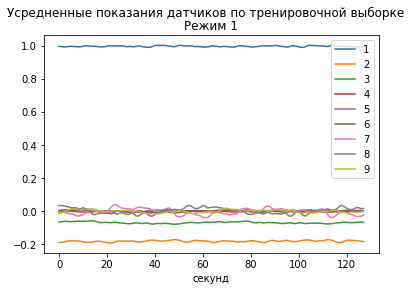

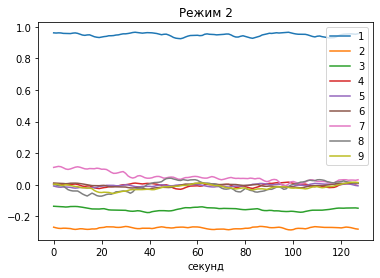

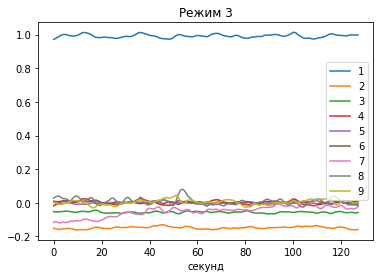

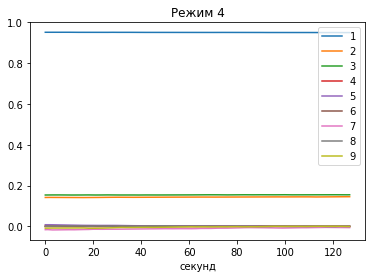

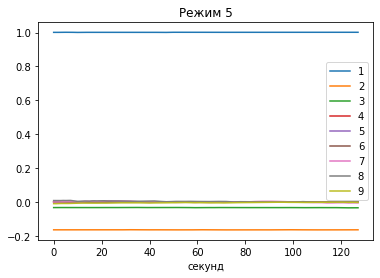

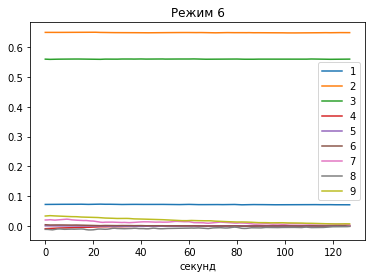

In [5]:
#Усредненные показания датчиков по всей тренировочной выборке
fig = plt.figure()
for m in range(1, 7):
    plt.title('Режим '+str(m))
    for k in range(1, 10):
        tmp_df = df_train_EDA.loc[y_train_EDA['Режим '+str(m)] == 1].copy()
        tmp_plot = [np.mean([tmp_df['Датчик '+str(k)][i][j] for i in tmp_df['Датчик '+str(k)].index.values]) for j in range(0, 128)]
        plt.plot(tmp_plot)
        plt.xlabel('секунд')
    plt.legend(range(1,10))
    fig.suptitle('Усредненные показания датчиков по тренировочной выборке')    
    plt.show()

**Выводы**.  
**Режим 2** отличается относительно большим среднее квадратичным отклонением по датчику 8 и слабым отрицательным линейным трендом в датчике 7.  
**Режим 3** отличается слабый положительный линейный тренд в датчике 7.  
**Режим 4** отличается от всех остальных по среднему значению датчика 2.  
**Режим 5** отличаются от остальных малым суммарным квадратичным отклонением и отличным от режима 4 датчиком 2.  
**Режим 6** отличается от всех остальных средними показателями датчиков 1, 2, 3, 4.  
А также, первые 3 режима отличаются высокими показателями среднеквадратичного отклонения. 
Датчики 5 и 6 визуально не дискриминируют режимы.
Наконец, в режиме 3 относительное большое среднеквадратичное отклонение по датчику 1 и имеется пик примерно после 50ой секунды (модуль максимального значения – среднее значение).


**Третий шаг.**
Для приближенной проверки устойчивости полученных гипотез проанализируем усредненные графики для первых 1000 наблюдений тренировочной выборки (<15%).

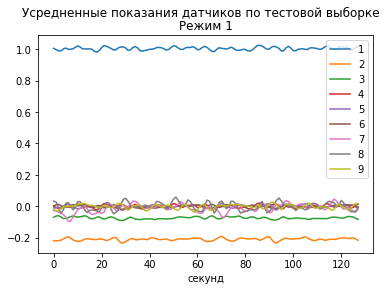

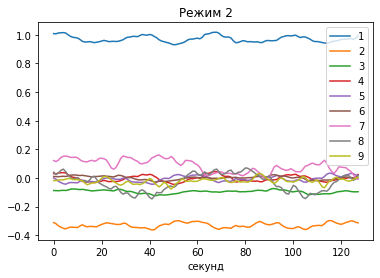

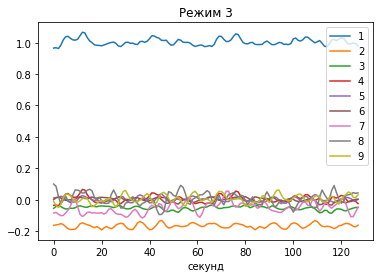

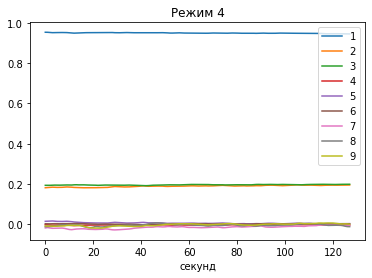

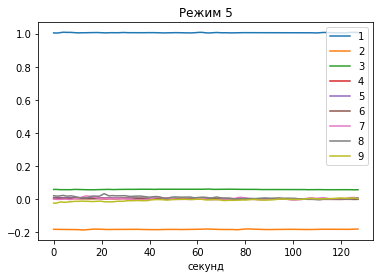

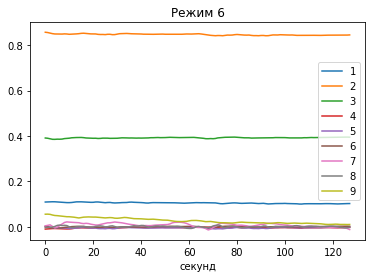

In [117]:
#Работаем с первыми N=1000 значениями тренировочного набора
y_train_EDA = y_train[0:1000]
df_train_EDA  = df_train[0:1000]

#Усредненные показания датчиков по тренировочной выборке
fig = plt.figure()
for m in range(1, 7):
    plt.title('Режим '+str(m))
    for k in range(1, 10):
        tmp_df = df_train_EDA .loc[y_train_EDA['Режим '+str(m)] == 1].copy()
        tmp_plot = [np.mean([tmp_df['Датчик '+str(k)][i][j] for i in tmp_df['Датчик '+str(k)].index.values]) for j in range(0, 128)]
        plt.plot(tmp_plot)
        plt.xlabel('секунд')
    plt.legend(range(1,10))
    fig.suptitle('Усредненные показания датчиков по 1000 наблюдениям тренировочной выборки')    
    plt.show()

**Выводы**.  
Картина в целом остается той же, что говорит об устойчивости полученных гипотез относительно наблюдений. Однако наблюдаются зашумления по первым трем режимам, поэтому имеет смысл добавить робастную оценку дисперсии – межквартильный размах. По этой же причине (+относительная малость выборки) пик по датчику 1 в режиме 3 предположительно является результатом сильного шума.

**Результаты**.  
Таким образом, согласно визуальному анализу, факторы с самыми высокими дискриминирующими свойствами:  
средние показатели датчиков 1, 2, 3, 4,  
коэффициент линейного тренда по датчику 7,  
среднее квадратичное отклонение по датчику 8, 
межквартильный размах по всем показателям датчиков,
суммарное средне квадратичное отклонение по всем показателям датчиков.  

# Создание факторного пространства

Сгенерируем факторное пространство в соответствии с результатами EDA.

## Тренировочный набор

In [46]:
#Создание тестового набора на основе всех средних, среднеквадратичных отклонений
#межквартильного размаха, коэффициента линейного тренда для датчика 7
#Для фичей Среднее значение и Средне квадратичное
def feature_forall(features_value, features_name, data):
    m =  [[features_value(data['Датчик '+str(j)][i]) for i in range(len(data))] for j in range(1,10)]
    df_metric = pd.DataFrame.from_records(m).transpose()
    df_metric.columns = [features_name+'Датчика '+str(i+1) for i in df_metric.columns]
    return df_metric
#Среднее значение
df_features_train =  feature_forall(np.mean, 'Среднее значение ', df_train)
#Средне квадратичное отклонение
df_features_train = pd.concat([df_features_train, feature_forall(np.std, 'Среднее квадратичное ', df_train)], axis=1)
#Сумма средне квадратичных отклонений
sumstd_df = df_features_train['Среднее квадратичное Датчика 1']
for i in range(2, 10):
    sumstd_df = sumstd_df+df_features_train['Среднее квадратичное Датчика '+str(i)]
df_features_train['Сумма среднеквадратичных отклонений'] = sumstd_df
#Межквартильный размах для каждого датчика
for j in range(1, 10):
    tmp = [np.quantile(df_train['Датчик '+str(j)][i], 0.75)-np.quantile(df_train['Датчик '+str(j)][i], 0.25) for i in range(len(df_train))]
    df_features_train['Межквартильный размах Датчика '+str(j)] = tmp
#Нормированный на максимум "Коэффициент линейного тренда" для датчика 7 
#= коэффициент линура подгонки под данные
tmp = []
for i in range(0, len(df_train['Датчик 7'])):
    dataa = df_train['Датчик 7'][i]
    y = np.array(dataa)
    x = np.arange(0, len(dataa))
    tmp.append(np.polyfit(x, y, 1)[0])
df_features_train['Линейный тренд Датчика 7'] = tmp
df_features_train['Линейный тренд Датчика 7'] = df_features_train['Линейный тренд Датчика 7']/max(df_features_train['Линейный тренд Датчика 7'])

df_features_train

,Среднее значение Датчика 1,Среднее значение Датчика 2,Среднее значение Датчика 3,Среднее значение Датчика 4,Среднее значение Датчика 5,Среднее значение Датчика 6,Среднее значение Датчика 7,Среднее значение Датчика 8,Среднее значение Датчика 9,Среднее квадратичное Датчика 1,...,Межквартильный размах Датчика 1,Межквартильный размах Датчика 2,Межквартильный размах Датчика 3,Межквартильный размах Датчика 4,Межквартильный размах Датчика 5,Межквартильный размах Датчика 6,Межквартильный размах Датчика 7,Межквартильный размах Датчика 8,Межквартильный размах Датчика 9,Линейный тренд Датчика 7
0,1.019305,-0.124262,0.099732,0.002269,-0.001655,-0.008126,0.022250,0.019403,0.009468,0.001791,...,0.002154,0.005065,0.004066,0.004812,0.005288,0.017835,0.021992,0.026714,0.008300,-0.011880
1,1.019448,-0.122936,0.096939,0.000174,0.000382,-0.005025,0.011926,-0.004314,0.006308,0.001932,...,0.002227,0.006164,0.005657,0.001970,0.008145,0.016466,0.010833,0.014572,0.010422,-0.005246
2,1.019927,-0.124997,0.092897,0.000428,-0.001222,-0.001703,-0.004150,-0.012640,0.004335,0.002904,...,0.003096,0.010128,0.008947,0.003138,0.012134,0.009852,0.036608,0.007812,0.013243,-0.020321
3,1.020349,-0.130493,0.087654,0.000329,-0.004753,-0.004947,-0.016228,-0.007697,-0.000352,0.002574,...,0.002786,0.004376,0.007824,0.003128,0.006488,0.007124,0.013132,0.009072,0.006907,0.003096
4,1.020255,-0.130209,0.084999,-0.000195,0.000298,-0.002330,-0.006483,-0.000166,-0.003957,0.001949,...,0.002506,0.004877,0.004742,0.002622,0.007183,0.005732,0.014639,0.009967,0.009755,0.011548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.993124,-0.224678,-0.068424,0.004552,-0.021010,-0.024090,-0.007579,-0.008430,0.016854,0.260127,...,0.288811,0.246403,0.239747,0.287873,0.248633,0.260426,0.675422,1.160857,0.470545,0.224028
7348,0.984407,-0.218768,-0.057635,-0.000767,0.004925,-0.012936,0.150959,-0.009665,-0.023482,0.247716,...,0.277866,0.207503,0.245473,0.276150,0.214334,0.260672,0.742800,1.167296,0.464901,-0.201542
7349,0.985348,-0.218529,-0.010961,-0.000863,0.000067,0.020906,-0.191333,0.051317,0.049415,0.253191,...,0.291103,0.225081,0.319103,0.294195,0.224121,0.335298,0.776992,1.225554,0.431990,-0.447140
7350,0.990478,-0.215775,-0.026930,0.002489,-0.000894,-0.016508,-0.390396,0.064625,0.040335,0.252923,...,0.284687,0.241898,0.292702,0.292455,0.237907,0.312320,0.599628,1.185702,0.368338,-0.101860


In [100]:
#удаление факторов, которые визуально не дискриминируют усредненные временные ряды
del_columns = ['Среднее значение Датчика 5', 
'Среднее значение Датчика 6',
'Среднее значение Датчика 7',
'Среднее значение Датчика 8',
'Среднее значение Датчика 9',
'Среднее квадратичное Датчика 1',
'Среднее квадратичное Датчика 2',
'Среднее квадратичное Датчика 3',
'Среднее квадратичное Датчика 4',
'Среднее квадратичное Датчика 5',
'Среднее квадратичное Датчика 6',
'Среднее квадратичное Датчика 7',
'Среднее квадратичное Датчика 9',
'Межквартильный размах Датчика 5',
'Межквартильный размах Датчика 6']
EDAdeleted_df_features_train = df_features_train.copy()
EDAdeleted_df_features_train.drop(del_columns, axis=1, inplace=True)
EDAdeleted_df_features_train

,Среднее значение Датчика 1,Среднее значение Датчика 2,Среднее значение Датчика 3,Среднее значение Датчика 4,Среднее квадратичное Датчика 8,Сумма среднеквадратичных отклонений,Межквартильный размах Датчика 1,Межквартильный размах Датчика 2,Межквартильный размах Датчика 3,Межквартильный размах Датчика 4,Межквартильный размах Датчика 7,Межквартильный размах Датчика 8,Межквартильный размах Датчика 9,Линейный тренд Датчика 7
0,1.019305,-0.124262,0.099732,0.002269,0.019828,0.075282,0.002154,0.005065,0.004066,0.004812,0.021992,0.026714,0.008300,-0.011880
1,1.019448,-0.122936,0.096939,0.000174,0.010356,0.063934,0.002227,0.006164,0.005657,0.001970,0.010833,0.014572,0.010422,-0.005246
2,1.019927,-0.124997,0.092897,0.000428,0.006920,0.070443,0.003096,0.010128,0.008947,0.003138,0.036608,0.007812,0.013243,-0.020321
3,1.020349,-0.130493,0.087654,0.000329,0.007793,0.048606,0.002786,0.004376,0.007824,0.003128,0.013132,0.009072,0.006907,0.003096
4,1.020255,-0.130209,0.084999,-0.000195,0.007815,0.051806,0.002506,0.004877,0.004742,0.002622,0.014639,0.009967,0.009755,0.011548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.993124,-0.224678,-0.068424,0.004552,0.829245,3.012648,0.288811,0.246403,0.239747,0.287873,0.675422,1.160857,0.470545,0.224028
7348,0.984407,-0.218768,-0.057635,-0.000767,0.839441,2.898894,0.277866,0.207503,0.245473,0.276150,0.742800,1.167296,0.464901,-0.201542
7349,0.985348,-0.218529,-0.010961,-0.000863,0.906278,3.063919,0.291103,0.225081,0.319103,0.294195,0.776992,1.225554,0.431990,-0.447140
7350,0.990478,-0.215775,-0.026930,0.002489,0.909678,2.926278,0.284687,0.241898,0.292702,0.292455,0.599628,1.185702,0.368338,-0.101860


## Тестовый набор

In [49]:
#Создание тестового набора на основе всех средних, среднеквадратичных отклонений
#межквартильного размаха, коэффициента линейного тренда для датчика 7
#Среднее значение
df_features_test =  feature_forall(np.mean, 'Среднее значение ', df_test)
#Средне квадратичное отклонение
df_features_test = pd.concat([df_features_test, feature_forall(np.std, 'Среднее квадратичное ', df_test)], axis=1)
#Сумма средне квадратичных отклонений
sumstd_df = df_features_test['Среднее квадратичное Датчика 1']
for i in range(2, 10):
    sumstd_df = sumstd_df+df_features_test['Среднее квадратичное Датчика '+str(i)]
df_features_test['Сумма среднеквадратичных отклонений'] = sumstd_df
#Межквартильный размах для каждого датчика
for j in range(1, 10):
    tmp = [np.quantile(df_test['Датчик '+str(j)][i], 0.75)-np.quantile(df_test['Датчик '+str(j)][i], 0.25) for i in range(len(df_test))]
    df_features_test['Межквартильный размах Датчика '+str(j)] = tmp
#Нормированный на максимум "Коэффициент линейного тренда" для датчика 7 
#= коэффициент линура подгонки под данные
tmp = []
for i in range(0, len(df_test['Датчик 7'])):
    help_1 = df_test['Датчик 7'][i]
    y = np.array(help_1)
    x = np.arange(0, len(help_1))
    tmp.append(np.polyfit(x, y, 1)[0])
df_features_test['Линейный тренд Датчика 7'] = tmp
df_features_test['Линейный тренд Датчика 7'] = df_features_test['Линейный тренд Датчика 7']/max(df_features_test['Линейный тренд Датчика 7'])

df_features_test

,Среднее значение Датчика 1,Среднее значение Датчика 2,Среднее значение Датчика 3,Среднее значение Датчика 4,Среднее значение Датчика 5,Среднее значение Датчика 6,Среднее значение Датчика 7,Среднее значение Датчика 8,Среднее значение Датчика 9,Среднее квадратичное Датчика 1,...,Межквартильный размах Датчика 1,Межквартильный размах Датчика 2,Межквартильный размах Датчика 3,Межквартильный размах Датчика 4,Межквартильный размах Датчика 5,Межквартильный размах Датчика 6,Межквартильный размах Датчика 7,Межквартильный размах Датчика 8,Межквартильный размах Датчика 9,Линейный тренд Датчика 7
0,0.993803,-0.267531,0.138710,-0.004204,-0.003224,0.030938,0.152280,-0.007880,0.045718,0.019505,...,0.013764,0.012940,0.026460,0.015428,0.016453,0.044213,0.143297,0.109070,0.036351,-0.092480
1,0.993323,-0.268710,0.140849,0.001742,0.002085,-0.003559,0.026941,-0.050997,0.041768,0.009345,...,0.005610,0.008027,0.019710,0.004933,0.009423,0.015669,0.112802,0.047194,0.027424,-0.059751
2,0.992927,-0.273769,0.134786,-0.000431,-0.004675,-0.003252,-0.021182,-0.041510,0.030026,0.003166,...,0.004356,0.011307,0.009667,0.005229,0.009253,0.012056,0.027068,0.017998,0.020004,0.008584
3,0.991127,-0.283087,0.131889,-0.001500,-0.008117,-0.003043,-0.029875,-0.023333,0.014165,0.003101,...,0.004257,0.012283,0.011401,0.004239,0.007992,0.011154,0.032657,0.034737,0.030798,-0.019186
4,0.990448,-0.290141,0.123383,-0.000565,-0.005617,-0.007010,-0.033330,-0.004688,-0.003396,0.003382,...,0.004632,0.006677,0.011665,0.005248,0.011403,0.009491,0.035875,0.022940,0.025874,0.020663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,0.972528,-0.277329,-0.230078,0.006714,-0.019015,0.003039,-0.118397,0.045051,0.051575,0.231131,...,0.246990,0.188847,0.182477,0.249294,0.186923,0.184018,0.564705,0.375738,0.351555,0.161553
2943,0.983719,-0.268153,-0.228845,0.017684,-0.011579,0.000790,0.092597,0.014079,0.012066,0.225604,...,0.255875,0.195422,0.161981,0.258055,0.192183,0.155796,0.795559,0.371342,0.618433,0.010627
2944,0.980682,-0.232996,-0.230343,0.014918,0.024765,-0.002471,-0.099051,0.072537,0.077493,0.217645,...,0.264384,0.148176,0.108739,0.266265,0.141991,0.113703,0.668461,0.456336,0.558744,-0.420891
2945,0.958825,-0.225295,-0.232670,-0.008240,0.018675,0.003901,-0.317900,0.078418,0.118935,0.219793,...,0.253314,0.132270,0.112802,0.252517,0.135773,0.114684,0.350853,0.457436,0.415711,0.054602


In [101]:
#удаление факторов, которые визуально не дискриминируют усредненные временные ряды
#и факторы неробастых оценок дисперсии
del_columns = ['Среднее значение Датчика 5', 
'Среднее значение Датчика 6',
'Среднее значение Датчика 7',
'Среднее значение Датчика 8',
'Среднее значение Датчика 9',
'Среднее квадратичное Датчика 1',
'Среднее квадратичное Датчика 2',
'Среднее квадратичное Датчика 3',
'Среднее квадратичное Датчика 4',
'Среднее квадратичное Датчика 5',
'Среднее квадратичное Датчика 6',
'Среднее квадратичное Датчика 7',
'Среднее квадратичное Датчика 9',
'Межквартильный размах Датчика 5',
'Межквартильный размах Датчика 6']
EDAdeleted_df_features_test = df_features_test.copy()
EDAdeleted_df_features_test.drop(del_columns, axis=1, inplace=True)
EDAdeleted_df_features_test

,Среднее значение Датчика 1,Среднее значение Датчика 2,Среднее значение Датчика 3,Среднее значение Датчика 4,Среднее квадратичное Датчика 8,Сумма среднеквадратичных отклонений,Межквартильный размах Датчика 1,Межквартильный размах Датчика 2,Межквартильный размах Датчика 3,Межквартильный размах Датчика 4,Межквартильный размах Датчика 7,Межквартильный размах Датчика 8,Межквартильный размах Датчика 9,Линейный тренд Датчика 7
0,0.993803,-0.267531,0.138710,-0.004204,0.142182,0.424450,0.013764,0.012940,0.026460,0.015428,0.143297,0.109070,0.036351,-0.092480
1,0.993323,-0.268710,0.140849,0.001742,0.055685,0.197944,0.005610,0.008027,0.019710,0.004933,0.112802,0.047194,0.027424,-0.059751
2,0.992927,-0.273769,0.134786,-0.000431,0.018389,0.096526,0.004356,0.011307,0.009667,0.005229,0.027068,0.017998,0.020004,0.008584
3,0.991127,-0.283087,0.131889,-0.001500,0.020964,0.109207,0.004257,0.012283,0.011401,0.004239,0.032657,0.034737,0.030798,-0.019186
4,0.990448,-0.290141,0.123383,-0.000565,0.018816,0.094908,0.004632,0.006677,0.011665,0.005248,0.035875,0.022940,0.025874,0.020663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,0.972528,-0.277329,-0.230078,0.006714,0.362786,2.142310,0.246990,0.188847,0.182477,0.249294,0.564705,0.375738,0.351555,0.161553
2943,0.983719,-0.268153,-0.228845,0.017684,0.369425,2.342635,0.255875,0.195422,0.161981,0.258055,0.795559,0.371342,0.618433,0.010627
2944,0.980682,-0.232996,-0.230343,0.014918,0.339755,2.264420,0.264384,0.148176,0.108739,0.266265,0.668461,0.456336,0.558744,-0.420891
2945,0.958825,-0.225295,-0.232670,-0.008240,0.341198,1.940852,0.253314,0.132270,0.112802,0.252517,0.350853,0.457436,0.415711,0.054602


Так как некоторые факторы (средние и оценки дисперсии) отличаются друг от друга на порядки, то их следует нормализовать перед построением модели.

# Построение моделей
## Подготовка к моделированию

In [102]:
#Подготовка данных для моделирования
#Факторы
df_train_Model = EDAdeleted_df_features_train.copy()
df_test_Model = EDAdeleted_df_features_test.copy()
#Нормализация факторов по среднему
df_train_Model = (df_train_Model-df_train_Model.mean())/df_train_Model.std() 
df_test_Model  = (df_test_Model -df_test_Model .mean())/df_test_Model .std() 
#Целевая переменная
y_train_Model = np.load("y_train.npy")
y_test_Model = np.load("y_test.npy")
y_train_Model = np.transpose(y_train_Model)
y_test_Model = np.transpose(y_test_Model)




В качестве первого алгоритма выбран метод опорных векторов с выбором параметра C методом кроссвалидации (5 подвыборок).

In [103]:
#Инициализация решателя для алгоритма метод опорных векторов с кроссвалидацией
def SVM_solver(df_train_Model, df_test_Model, y_train_Model, y_test_Model):
    print('Метод опорных векторов')
    start_time = time.clock() 
    #Тренировка бинарных моделей, oneVSall
    y_pred_svm = [0]*6
    pred_score_svm = [[0]*6 for i in range(3)]
    test_score_svm = [[0]*6 for i in range(3)]
    clf_svm_fitted = []
    for i in range(6):
        clf_svm = SVC()
        C_s = np.linspace(0, 50, 30)
        clf = GridSearchCV(estimator=clf_svm, param_grid=dict(C=C_s), n_jobs=-1)
        clf.fit(df_train_Model, y_train_Model[i])
        Cbest = clf.best_estimator_.C
        clf_svm = SVC(C=Cbest, max_iter=10000)
        clf_svm_fitted.append(clf_svm.fit(df_train_Model, y_train_Model[i]))
        y_pred_svm[i] = clf_svm.predict(df_test_Model)
        test_score_svm[0][i] = roc_auc_score(y_test_Model[i], y_pred_svm[i])
        test_score_svm[1][i] = precision_score(y_test_Model[i], y_pred_svm[i])
        test_score_svm[2][i] = recall_score(y_test_Model[i], y_pred_svm[i])
        print('Модель для Режима '+str(i+1)+' готова')

    finish_time = time.clock() 
    print('Время расчета '+str(finish_time-start_time))

    svm_scores = pd.DataFrame(np.transpose(test_score_svm),index=[1,2,3,4,5,6],columns=['roc-auc','precision','recall'])
    print('Метрики бинарных классификаторов')
    display(svm_scores)
    #Рассчитаем среднеевзвешенные по объему тренировочной выборки метрики:
    test_values = [496,471,420,491,532,537]
    roc_auc_weighted = sum(svm_scores['roc-auc'][g+1] * test_values[g] / sum(test_values) for g in range(len(svm_scores['roc-auc'])))
    precision_weighted = sum(svm_scores['precision'][g+1] * test_values[g] / sum(test_values) for g in range(len(svm_scores['precision'])))
    recall_weighted = sum(svm_scores['recall'][g+1] * test_values[g] / sum(test_values) for g in range(len(svm_scores['recall'])))
    print('Cреднеевзвешенные по классовому объему тренировочной выборки метрики')
    print([roc_auc_weighted,precision_weighted, recall_weighted])
    

В качестве второго алгоритма выбран перцептрон с одним скрытым слоем (как самый простой для небольшого времени обучения относительно SVM), выбор параметров регуляризации и количества узлов в скрытом слое проводится методом кроссвалидации (5 подвыборок).

In [104]:
#Инициализация решателя для алгоритма перцептрон с одним скрытым слоем с кроссвалидацией по количеству узлов
#и параметру регуляризации
def MLP_solver(df_train_Model, df_test_Model, y_train_Model, y_test_Model):
    print('Перцептрон')
    start_time = time.clock() 
    y_pred_perc = [0]*6
    pred_score_perc = [[0]*6 for i in range(3)]
    test_score_perc = [[0]*6 for i in range(3)]
    clf_perc_fitted = []
    for i in range(6):
        clf_perc = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(6,), random_state=1)
        alpha_s = np.logspace(-2, 1, 10)
        hidden_layer_sizes_s = [(3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,)]
        clf = GridSearchCV(estimator=clf_perc, param_grid=dict(alpha=alpha_s, hidden_layer_sizes=hidden_layer_sizes_s), n_jobs=-1)   
        clf.fit(df_train_Model, y_train_Model[i])
        alphabest = clf.best_estimator_.alpha
        hidden_layer_sizesbest = clf.best_estimator_.hidden_layer_sizes
        clf_perc = MLPClassifier(solver='lbfgs', alpha=alphabest, hidden_layer_sizes=hidden_layer_sizesbest, random_state=1)
        clf_perc_fitted.append(clf_perc.fit(df_train_Model, y_train_Model[i]))
        y_pred_perc[i] = clf_perc.predict(df_test_Model)
        test_score_perc[0][i] = roc_auc_score(y_test_Model[i], y_pred_perc[i])
        test_score_perc[1][i] = precision_score(y_test_Model[i], y_pred_perc[i])
        test_score_perc[2][i] = recall_score(y_test_Model[i], y_pred_perc[i])
        print('Модель для Режима '+str(i+1)+' готова')
    finish_time = time.clock() 
    print('Время расчета '+str(finish_time-start_time))

    perc_scores = pd.DataFrame(np.transpose(test_score_perc),index=[1,2,3,4,5,6],columns=['roc-auc','precision','recall'])
    print('Метрики бинарных классификаторов')
    display(perc_scores)
    #Рассчитаем среднеевзвешенные по объему тренировочной выборки метрики:
    test_values = [496, 471, 420, 491, 532, 537]
    roc_auc_weighted = sum(perc_scores['roc-auc'][g+1] * test_values[g] / sum(test_values) for g in range(len(perc_scores['roc-auc'])))
    precision_weighted = sum(perc_scores['precision'][g+1] * test_values[g] / sum(test_values) for g in range(len(perc_scores['precision'])))
    recall_weighted = sum(perc_scores['recall'][g+1] * test_values[g] / sum(test_values) for g in range(len(perc_scores['recall'])))
    print('Cреднеевзвешенные по классовому объему тренировочной выборки метрики')
    print([roc_auc_weighted,precision_weighted, recall_weighted])


## Моделирование

In [105]:
SVM_solver(df_train_Model, df_test_Model, y_train_Model, y_test_Model)

Метод опорных векторов
Модель для Режима 1 готова
Модель для Режима 2 готова
Модель для Режима 3 готова
Модель для Режима 4 готова
Модель для Режима 5 готова
Модель для Режима 6 готова
Время расчета 41.846053199999915
Метрики бинарных классификаторов


,roc-auc,precision,recall
1,0.855272,0.835991,0.739919
2,0.838819,0.773455,0.717622
3,0.867517,0.758140,0.776190
4,0.922611,0.904051,0.863544
5,0.923510,0.842294,0.883459
6,1.000000,1.000000,1.000000


Cреднеевзвешенные по классовому объему тренировочной выборки метрики
[0.904297602358172, 0.8572640150488691, 0.835425856803529]


**Выводы.** Порог в 0.88 не превышен для показателей precision и recall.
Самые худший классификаторы получлись для режима 2, 3, что можно объяснить малыми долями этих классов в обучающей выборки и относительно сильным зашумлением в данных.

In [82]:
MLP_solver(df_train_Model, df_test_Model, y_train_Model, y_test_Model)

Перцептрон
Модель для Режима 1 готова
Модель для Режима 2 готова
Модель для Режима 3 готова
Модель для Режима 4 готова
Модель для Режима 5 готова
Модель для Режима 6 готова
Время расчета 342.9102604999998
Метрики бинарных классификаторов


,roc-auc,precision,recall
1,0.870874,0.760155,0.792339
2,0.805103,0.748780,0.651805
3,0.861179,0.723214,0.771429
4,0.921591,0.943694,0.853360
5,0.929465,0.935484,0.872180
6,1.000000,1.000000,1.000000


Cреднеевзвешенные по классовому объему тренировочной выборки метрики
[0.9015365821674713, 0.8590069165925005, 0.829317950458093]


**Выводы.** Использование перцептрона привело к ухудшению показателей метрик качества. Алгоритм работает более чем в 7 раз медленнее.

# Уточнение факторного пространства

In [107]:
#Подготовка данных для моделирования
#Факторы
df_train_Model = df_features_train.copy()
df_test_Model = df_features_test.copy()
#Нормализация факторов по среднему
df_train_Model = (df_train_Model-df_train_Model.mean())/df_train_Model.std() 
df_test_Model  = (df_test_Model -df_test_Model .mean())/df_test_Model .std() 
#Целевая переменная
y_train_Model = np.load("y_train.npy")
y_test_Model = np.load("y_test.npy")
y_train_Model = np.transpose(y_train_Model)
y_test_Model = np.transpose(y_test_Model)

Сравним между собой распределения изначально исключенных из моделирования средних значений датчиков (5, 6, 7, 8) для режимов с худшими показателями метрик (режимы 2, 3) 

Воспользуемся тестом Вилксона, который не требует нормальности распределений факторов. 

In [108]:
#Wilcoxon signed-rank test

for i in ['Среднее значение Датчика 5',  'Среднее значение Датчика 6', 'Среднее значение Датчика 7', 'Среднее значение Датчика 8', 'Среднее значение Датчика 9']:
    aa1 = df_train_Model.copy().loc[y_train['Режим '+str(2)] == 1][i]
    aa2 = df_train_Model.copy().loc[y_train['Режим '+str(3)] == 1][i]
    stat, p = ranksums(aa1, aa2)
    print(p)

8.095321448001078e-08
3.8177659061537574e-05
9.193749093455384e-13
5.544617171442905e-06
7.901258800306254e-08


Показатели p-value ниже 0.05. Значит распределения отличны друг от друга.
Для сравнения рассмотрим режимы 5 и 6

In [109]:
for i in ['Среднее значение Датчика 5',  'Среднее значение Датчика 6', 'Среднее значение Датчика 7', 'Среднее значение Датчика 8', 'Среднее значение Датчика 9']:
    aa1 = df_train_Model.copy().loc[y_train['Режим '+str(5)] == 1][i]
    aa2 = df_train_Model.copy().loc[y_train['Режим '+str(6)] == 1][i]
    stat, p = ranksums(aa1, aa2)
    print(p)

0.05814775939259293
0.09738866820475253
0.07438477364753115
0.00051928509421774
0.003683581975291421


Действительно, как и было видно на графиках, распределения этих показателей более похожи друг на друга. 

Дополним факторное пространство средними значениями, неробастыми оценками дисперсии, исключая датчики 5 и 6, показания которых во всех режимах визуально (в некоторых случаях статистически) одинаковые и перетренируем модели.

In [119]:
#удаление факторов, которые визуально не дискриминируют усредненные временные ряды
#и факторы неробастых оценок дисперсии
del_columns = ['Среднее значение Датчика 5', 
'Среднее значение Датчика 6',
'Среднее квадратичное Датчика 5',
'Среднее квадратичное Датчика 6',
'Межквартильный размах Датчика 5',
'Межквартильный размах Датчика 6']
EDAplus_deleted_df_features_test = df_features_test.copy()
EDAplus_deleted_df_features_test.drop(del_columns, axis=1, inplace=True)
EDAplus_deleted_df_features_train = df_features_train.copy()
EDAplus_deleted_df_features_train.drop(del_columns, axis=1, inplace=True)

#Подготовка данных для моделирования
#Факторы
df_train_Model = EDAplus_deleted_df_features_train.copy()
df_test_Model = EDAplus_deleted_df_features_test.copy()
#Нормализация факторов по среднему
df_train_Model = (df_train_Model-df_train_Model.mean())/df_train_Model.std() 
df_test_Model  = (df_test_Model -df_test_Model .mean())/df_test_Model .std() 
#Целевая переменная
y_train_Model = np.load("y_train.npy")
y_test_Model = np.load("y_test.npy")
y_train_Model = np.transpose(y_train_Model)
y_test_Model = np.transpose(y_test_Model)

SVM_solver(df_train_Model, df_test_Model, y_train_Model, y_test_Model)
MLP_solver(df_train_Model, df_test_Model, y_train_Model, y_test_Model)

Метод опорных векторов
Модель для Режима 1 готова
Модель для Режима 2 готова
Модель для Режима 3 готова
Модель для Режима 4 готова
Модель для Режима 5 готова
Модель для Режима 6 готова
Время расчета 54.16070109999964
Метрики бинарных классификаторов


,roc-auc,precision,recall
1,0.915611,0.897872,0.850806
2,0.873794,0.833713,0.777070
3,0.911357,0.805369,0.857143
4,0.942163,0.900609,0.904277
5,0.947545,0.923810,0.911654
6,1.000000,1.000000,1.000000


Cреднеевзвешенные по классовому объему тренировочной выборки метрики
[0.93388742202884, 0.898182551586694, 0.8870037326094333]
Перцептрон
Модель для Режима 1 готова
Модель для Режима 2 готова
Модель для Режима 3 готова
Модель для Режима 4 готова
Модель для Режима 5 готова
Модель для Режима 6 готова
Время расчета 341.5009969999992
Метрики бинарных классификаторов


,roc-auc,precision,recall
1,0.910464,0.820809,0.858871
2,0.851045,0.830918,0.730361
3,0.911387,0.723529,0.878571
4,0.944613,0.784380,0.940937
5,0.883173,0.964789,0.772556
6,1.000000,1.000000,1.000000


Cреднеевзвешенные по классовому объему тренировочной выборки метрики
[0.9181769911299418, 0.8611348472174177, 0.8649474041398032]


**Результаты и выводы.**  

• Количество факторов сокращено примерно в 50 раз (с 9*128 до 23).

• Визуальный анализ усредненных по наблюдениям временных рядов не выявил сразу все значимые факторы. Соответственно, процедура усреднения для текущих данных и целевых метрик приводит к потере важной информации.

• Модель перцептрона с одним слоем приводит к худшим метрикам и замедлению обучения примерно в 7 раз.

• Получена модель SVM с кроссвалидацией по параметру С, которая превысила порог точности 0.88 по всем параметрам точности на дополненном факторном пространстве.

• Для дальнейшего повышения точности рекомендуется естественно или искуственно (используя модели временных рядов и/или методы сэмплирования) добрать наблюдений для режима 3.



## [Ильдар А.](https://drive.google.com/file/d/1U_eSjm75ZaUgdOj6WEdcuzDxSr07c5ar/view)